In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
import sys
import os
current_dir = os.path.abspath('.')
if current_dir not in sys.path:
    sys.path.insert(0, current_dir)

from in2D.classifying.classes.simplex_tree_classifier import SimplexTreeClassifier
import matplotlib.patches as patches
from in2D.classifying.classes.simplex_tree_classifier import SimplexTreeClassifier
from in2D.classifying.classes.utilss.plane_equation import PlaneEquation

In [2]:
def make_meshgrid(x, y, h=.01):
    x_min, x_max = x.min() , x.max()
    y_min, y_max = y.min() , y.max()

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, clf, xx, yy, xy, **params):
    Z = clf.predict(xy)
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out


In [3]:
N=1000
C=1000
gamma=0.01
D=2 #dimension
t=8 #polytope order

X = np.random.normal(0,1,(N,D))
ws= np.random.normal(0,1,(t,D))
ws = ws / (np.linalg.norm(ws,axis=1).reshape(-1,1))

u=np.random.uniform(0,1,(N,1))
X=X/(np.linalg.norm(X,axis=1).reshape(-1,1))*(u**(1/D))

y=np.ones(N)

for index in range(N):
    z = 1
    for w in ws :
        if((X[index].dot(w)- 0.5 - gamma) > 0):
            z = -1
        else :
            if ((X[index].dot(w) - 0.4 -gamma) > 0):
                z =0
    y[index]=z

X=(X[y!= 0]+ [1,1])/2
y=y[y!= 0]

print("Dataset created:")
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"Classes: {np.unique(y)}")


Dataset created:
X shape: (753, 2)
y shape: (753,)
Classes: [-1.  1.]


Running for subdivision_levels k=1
(753, 4)
Running for subdivision_levels k=2
(753, 7)
Running for subdivision_levels k=3
(753, 16)
Running for subdivision_levels k=4
(753, 43)


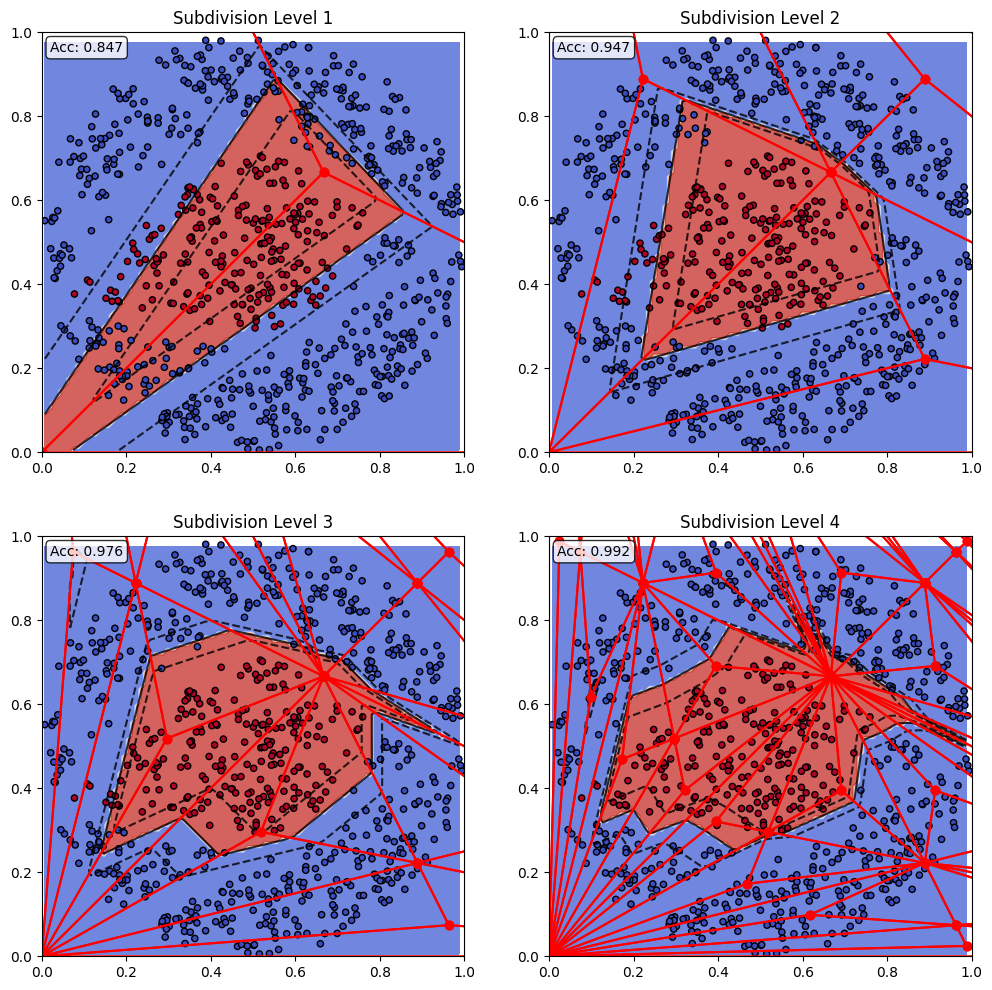

In [4]:
fig, sub = plt.subplots(2, 2, figsize=(12, 12))
xx, yy = make_meshgrid(X[:, 0], X[:, 1])

for k, title, ax in zip(range(1, 5), range(1, 5), sub.flatten()):
    print(f"Running for subdivision_levels k={k}")
    
    model = SimplexTreeClassifier(
        vertices=[(0, 0), (2, 0), (0, 2)], # Use a triangle that contains the [0,1]x[0,1] data space
        regularization=C,
        subdivision_levels=k,
        classifier_type='svc'
    )
    
    model.fit(X, y)
    
    xy = model.transform(np.vstack([xx.ravel(), yy.ravel()]).T)

    plot_contours(ax, model.classifier, xx, yy, xy,
                 cmap=plt.cm.coolwarm, alpha=0.8)
    
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_title(f"Subdivision Level {title}")

    if hasattr(model.classifier, "decision_function"):
        Z = model.classifier.decision_function(xy).reshape(xx.shape)
        ax.contour(xx, yy, Z, colors='k', levels=[-1, 0, 1], alpha=0.8,
                    linestyles=['--', '-', '--'])

    boundaries = model.get_simplex_boundaries()
    for boundary in boundaries:
        if len(boundary) >= 3:
            closed_boundary = boundary + [boundary[0]]
            x_coords = [point[0] for point in closed_boundary]
            y_coords = [point[1] for point in closed_boundary]
            ax.plot(x_coords, y_coords, 'ro-')
            
    accuracy = model.classifier.score(model.transform(X), y)
    ax.text(0.02, 0.98, f'Acc: {accuracy:.3f}', transform=ax.transAxes, 
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.show()

### Crossed Plane Detection

Running for subdivision_levels k=1
(753, 4)
Running for subdivision_levels k=2
(753, 7)
Running for subdivision_levels k=3
(753, 16)
Running for subdivision_levels k=4
(753, 43)


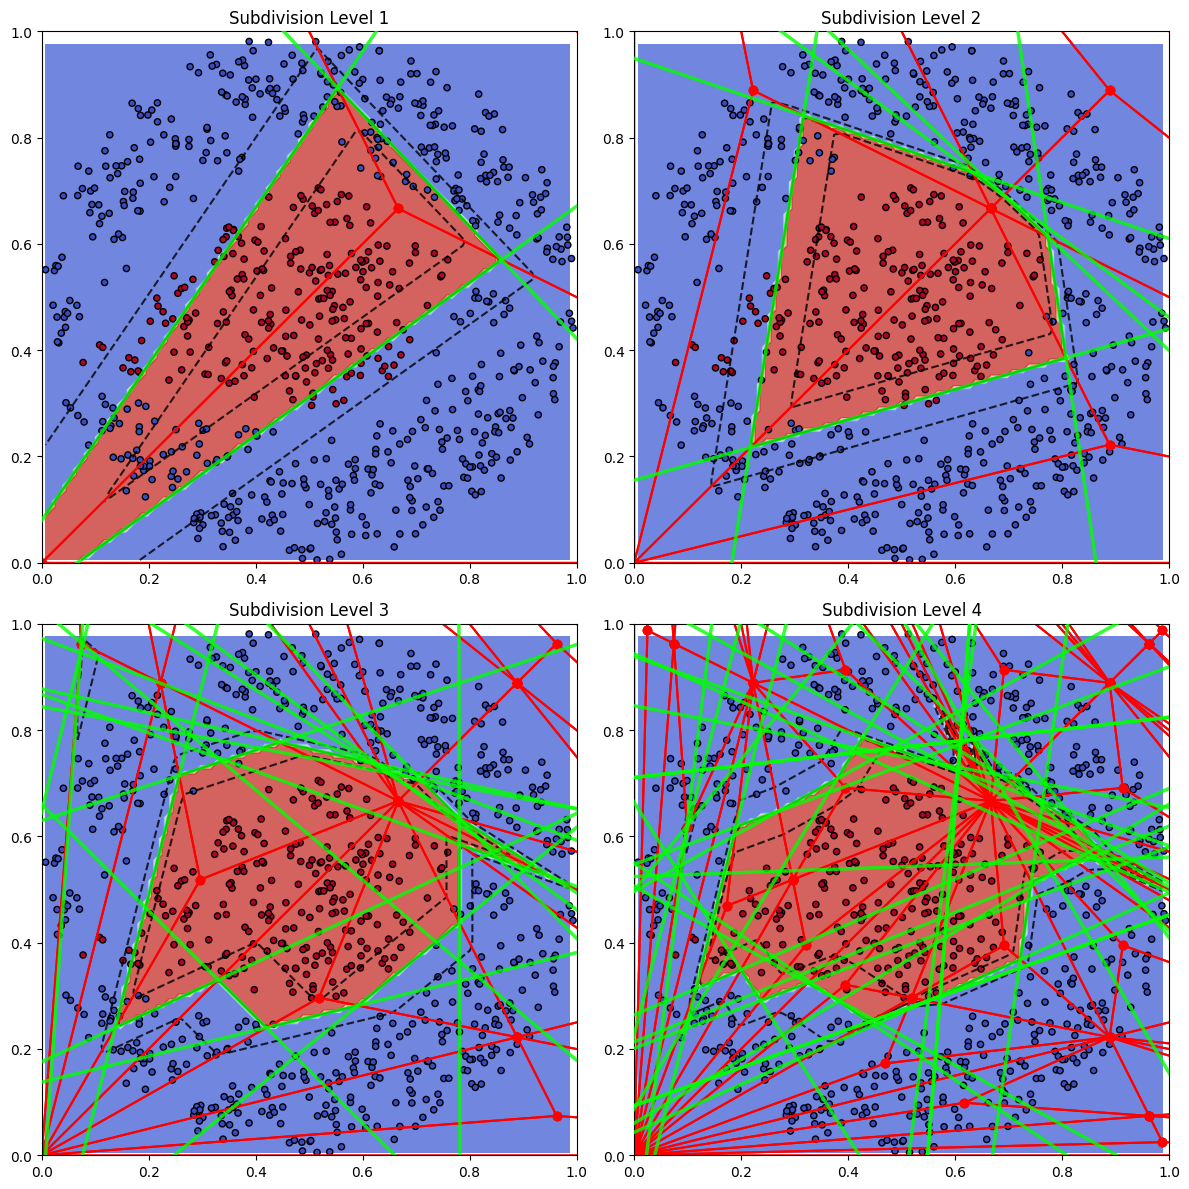

In [5]:
fig, sub = plt.subplots(2, 2, figsize=(12, 12))
xx, yy = make_meshgrid(X[:, 0], X[:, 1])

for k, ax in zip(range(1, 5), sub.flatten()):
    print(f"Running for subdivision_levels k={k}")
    
    model = SimplexTreeClassifier(
        vertices=[(0, 0), (2, 0), (0, 2)],
        regularization=C,
        subdivision_levels=k,
        classifier_type='svc'
    )
    
    model.fit(X, y)
    
    xy = model.transform(np.vstack([xx.ravel(), yy.ravel()]).T)

    plot_contours(ax, model.classifier, xx, yy, xy,
                 cmap=plt.cm.coolwarm, alpha=0.8)
    
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_title(f"Subdivision Level {k}")

    if hasattr(model.classifier, "decision_function"):
        Z = model.classifier.decision_function(xy).reshape(xx.shape)
        ax.contour(xx, yy, Z, colors='k', levels=[-1, 0, 1], alpha=0.8,
                    linestyles=['--', '-', '--'])

    boundaries = model.get_simplex_boundaries()
    for boundary in boundaries:
        if len(boundary) >= 3:
            closed_boundary = boundary + [boundary[0]]
            x_coords = [point[0] for point in closed_boundary]
            y_coords = [point[1] for point in closed_boundary]
            ax.plot(x_coords, y_coords, 'ro-')
    
    plane_equations = model.compute_svm_plane_equations()
    
    for plane_info in plane_equations:
        coefficients = plane_info['coefficients']
        a, b, c = coefficients
        
        # Create a line across the entire plot
        # If the line is more vertical (|a| > |b|), solve for x given y
        # If the line is more horizontal (|b| > |a|), solve for y given x
        if abs(b) > abs(a):
            # Solve for y: y = -(ax + c) / b
            x_line = np.array([0, 1])
            y_line = -(a * x_line + c) / b
        else:
            # Solve for x: x = -(by + c) / a
            y_line = np.array([0, 1])
            x_line = -(b * y_line + c) / a
        
        ax.plot(x_line, y_line, 'lime', linewidth=2.5, alpha=0.8, zorder=10)
        
        # vertices = plane_info['vertices']
        # if len(vertices) >= 3:
        #     triangle = patches.Polygon(vertices, facecolor='yellow', 
        #                               alpha=0.2, edgecolor='orange', linewidth=1)
        #     ax.add_patch(triangle)
            

plt.tight_layout()
plt.show()

In [6]:
MAX_SUBDIVISION = 3

Running for subdivision_levels k=1
(753, 4)
Running for subdivision_levels k=2
(753, 7)
Running for subdivision_levels k=3
(753, 16)


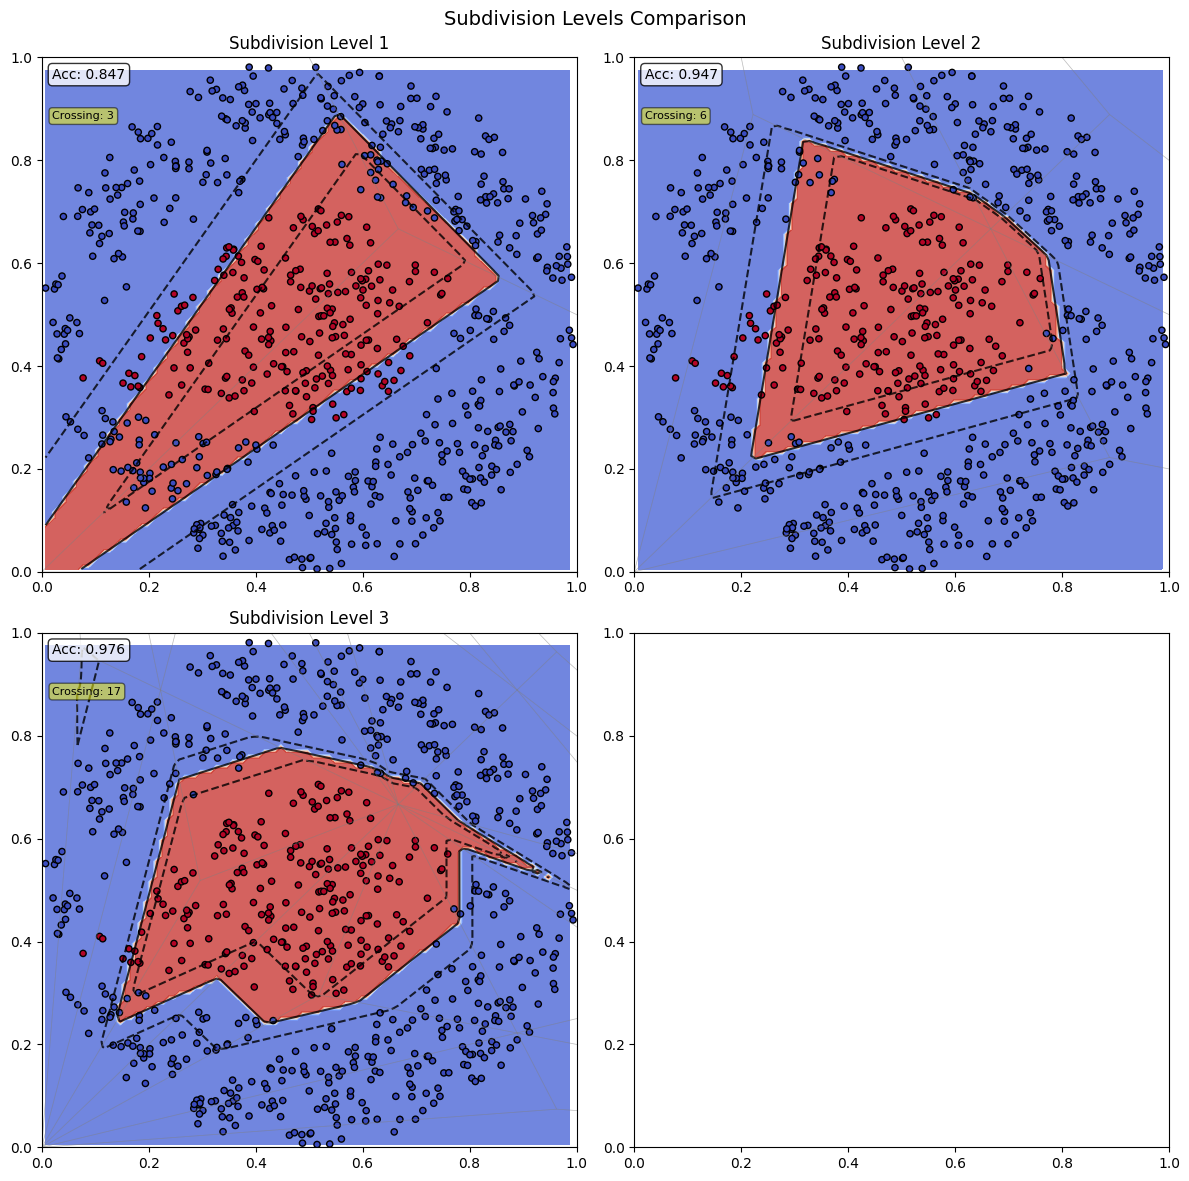

Last model with subdivision level 3 is ready for redundancy analysis


In [7]:
fig, sub = plt.subplots(2, 2, figsize=(12, 12))
xx, yy = make_meshgrid(X[:, 0], X[:, 1])

models = []

for k, ax in zip(range(1, MAX_SUBDIVISION+1), sub.flatten()):
    print(f"Running for subdivision_levels k={k}")
    
    model = SimplexTreeClassifier(
        vertices=[(0, 0), (2, 0), (0, 2)], 
        regularization=C,
        subdivision_levels=k, 
        classifier_type='svc'
    )
    
    model.fit(X, y)
    models.append(model)  # Store model for later use
    
    xy = model.transform(np.vstack([xx.ravel(), yy.ravel()]).T)

    plot_contours(ax, model.classifier, xx, yy, xy,
                 cmap=plt.cm.coolwarm, alpha=0.8)
    
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_title(f"Subdivision Level {k}")  # Fixed: use k instead of title

    if hasattr(model.classifier, "decision_function"):
        Z = model.classifier.decision_function(xy).reshape(xx.shape)
        ax.contour(xx, yy, Z, colors='k', levels=[-1, 0, 1], alpha=0.8,
                    linestyles=['--', '-', '--'])

    boundaries = model.get_simplex_boundaries()
    for boundary in boundaries:
        if len(boundary) >= 3:
            closed_boundary = boundary + [boundary[0]]
            x_coords = [point[0] for point in closed_boundary]
            y_coords = [point[1] for point in closed_boundary]
            ax.plot(x_coords, y_coords, 'gray', linewidth=0.5, alpha=0.3)
    
    # Count and display crossing planes
    try:
        crossing_planes = model.identify_svm_crossing_simplices()
        ax.text(0.02, 0.88, f'Crossing: {len(crossing_planes)}', 
                transform=ax.transAxes, fontsize=8,
                bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5))
    except:
        pass
            
    accuracy = model.classifier.score(model.transform(X), y)
    ax.text(0.02, 0.98, f'Acc: {accuracy:.3f}', transform=ax.transAxes, 
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.suptitle('Subdivision Levels Comparison', fontsize=14)
plt.tight_layout()
plt.show()

model = models[-1]
print(f"Last model with subdivision level {MAX_SUBDIVISION} is ready for redundancy analysis")

In [26]:
result = model.find_redundancy_groups(angle_threshold = 0.97)

planes_to_keep = set(result['planes_to_keep'])
planes_to_remove = set(result['planes_to_remove'])
plane_equations = result['plane_equations']


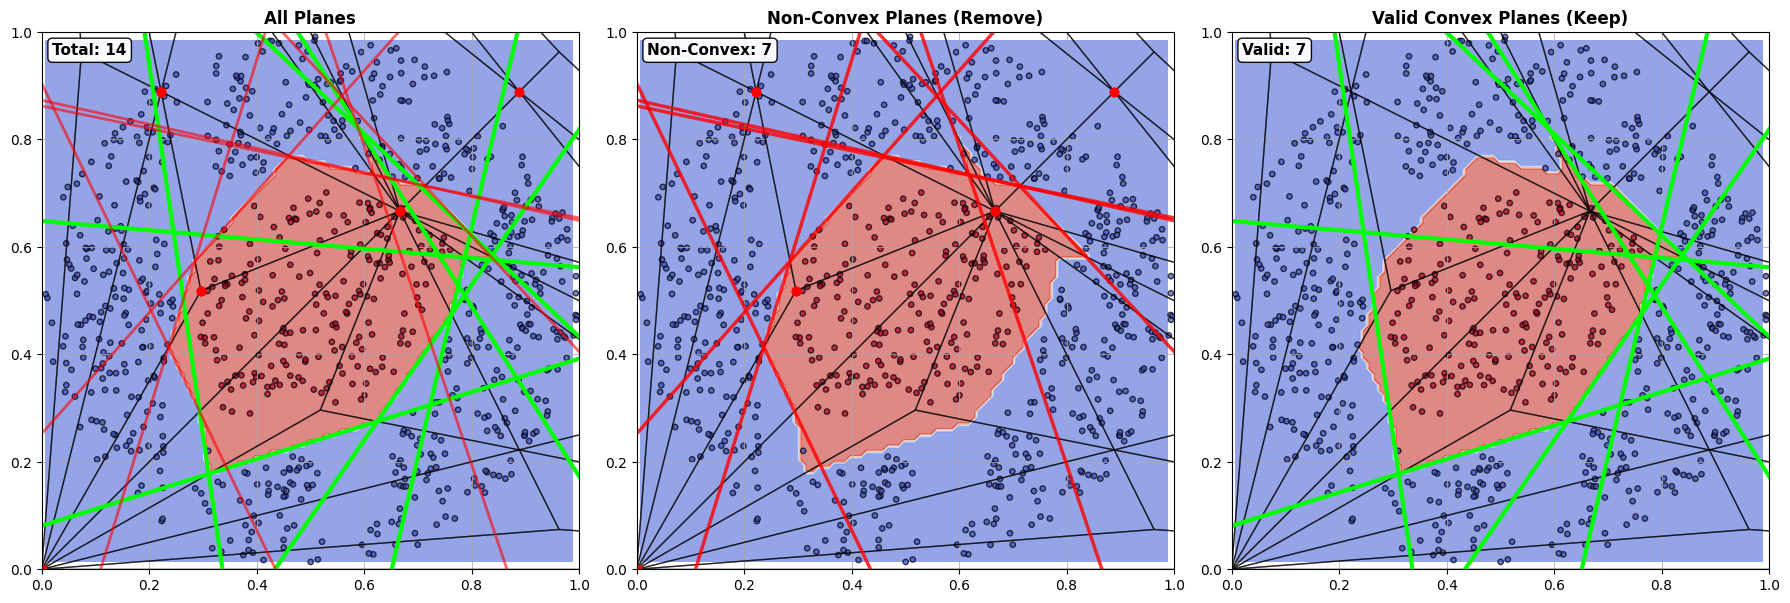

In [27]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
titles = ['All Planes', 'Non-Convex Planes (Remove)', 'Valid Convex Planes (Keep)']

for ax, title in zip(axes, titles):
    ax.set_title(title, fontsize=12, fontweight='bold')
    
    plot_contours(ax, model.classifier, xx, yy, 
                  model.transform(np.vstack([xx.ravel(), yy.ravel()]).T),
                  cmap=plt.cm.coolwarm, alpha=0.6) 
    
    boundaries = model.get_simplex_boundaries()
    for boundary in boundaries:
        if len(boundary) >= 3:
            closed = boundary + [boundary[0]]
            xs, ys = zip(*closed)
            ax.plot(xs, ys, 'black', linewidth=1, alpha=0.6)
    
    for i, plane in enumerate(plane_equations):
        coeffs = plane['coefficients']
        a, b, c = coeffs
        
        is_kept = i in planes_to_keep
        is_removed = i in planes_to_remove
        
        if title == 'All Planes':
            color = 'lime' if is_kept else 'red'
            alpha = 1.0 if is_kept else 0.6
            linewidth = 3 if is_kept else 2
            draw = True
        elif title == 'Non-Convex Planes (Remove)':
            color = 'red'
            alpha = 0.8
            linewidth = 2.5
            draw = is_removed
        else:  # 'Valid Convex Planes (Keep)'
            color = 'lime'
            alpha = 1.0
            linewidth = 3
            draw = is_kept
        
        if draw:
            if abs(b) > abs(a):
                x_line = np.array([0, 1])
                y_line = -(a * x_line + c) / b
            else:
                y_line = np.array([0, 1])
                x_line = -(b * y_line + c) / a
            
            ax.plot(x_line, y_line, color=color, linewidth=linewidth, alpha=alpha)
            
            # Mark non-convex simplices with their vertices
            if is_removed and title != 'Valid Convex Planes (Keep)':
                vertices = plane['vertices']
                for vertex in vertices:
                    ax.plot(vertex[0], vertex[1], 'ro', markersize=6)
    
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, s=15, alpha=0.7, edgecolors='k')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.8, color='darkgray', linewidth=0.7)
    
    if title == 'All Planes':
        text = f'Total: {len(plane_equations)}'
    elif 'Remove' in title:
        text = f'Non-Convex: {len(planes_to_remove)}'
    else:
        text = f'Valid: {len(planes_to_keep)}'
    
    ax.text(0.02, 0.98, text, transform=ax.transAxes, 
            verticalalignment='top', fontsize=11, fontweight='bold',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.95))

plt.tight_layout()
plt.show()